In [ ]:
# 1)
# Her hafta için kaç kişi dengue olacak?
# Bunu çevresel verileri (sıcaklık, yağış, nem, NDVI, rüzgar, zaman…) kullanarak tahmin edeceğiz.
# Buna ana model deniyor.

# 2)
# ✔ Bir tane yüksek dereceli polinom modeli (Polynomial Regression, k derece)
# ✔ Bir tane literatürde kullanılan bir model (Random Forest, XGBoost, LSTM vs.)
# Bu iki modeli karşılaştıracağız → hangisi daha iyi tahmin yapıyor?

# 3)
#Hangi değişkenlerin (features) dengue’yi en çok etkilediğini bulacağız.
#İlk isteğimiz:
#Yani:
#Nem mi daha etkili?
#Yağış mı daha güçlü bir belirteç?
#NDVI mı daha önemli?
#Sıcaklık mı en kritik?
#Bu analizleri raporlayacağız.

# 4)
#Zaman serisi modeli ile geleceği tahmin etmek (önceden tahmin)
#İkinci isteğimiz:
# Vaka sayısını daha haftası gelmeden tahmin et.
#Yani:
# 1 hafta önceden tahmin
# 2 hafta önceden tahmin
# 3 hafta önceden tahmin
# Hangisi daha doğru sonuç veriyor? → bunu yazmamız gerekiyor.

# 5) Sonuçları raporlamak
#Projenin sonunda:
#Modellerin MAE değerleri
#Kullanılan özelliklerin önemi
#Şehir bazlı farklılıklar
#En iyi tahmin süresi (kaç hafta önceden daha iyi)
#bunları yazacağız.

In [5]:
import pandas as pd
import numpy as np

In [6]:
train_features = pd.read_csv("Data/dengue_features_train.csv")
train_labels = pd.read_csv("Data/dengue_labels_train.csv")
test_features = pd.read_csv("Data/dengue_features_test.csv")

train_features.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [7]:
# Korelasyon analizi yapmadan önce ön tahminlerimizi yapalım:

# city → hangi şehirde ölçüldü?
# year → hangi yılda?
# weekofyear → yılın kaçıncı haftası?
# total_cases → o hafta kaç kişi dengue oldu (tahmin edeceğimiz şey).

# ➤ NDVI değerleri (Bitki örtüsü ölçümü)
# NDVI = Normalized Difference Vegetation Index
# Uydu görüntülerinden alınır. Yani “bitki yoğunluğu”.
#ndvi_ne → Kuzeydoğu bölgesindeki bitki yoğunluğu
#ndvi_nw → Kuzeybatı bölgesindeki bitki yoğunluğu
#ndvi_se → Güneydoğu bölgesindeki bitki yoğunluğu
#ndvi_sw → Güneybatı bölgesindeki bitki yoğunluğu

# ➤ NDVI ne işe yarıyor?
#Bitki örtüsü sivrisinek popülasyonunu etkiler.
#Bitki = nem = sivrisinek yuvası = daha fazla dengue.
#NDVI yüksekse → dengue artabilir.

# ➤ precipitation_amt_mm — Yağış miktarı (mm)
#Sivrisinekler su birikintisinde ürer.
#Yağmur ↑ → su birikir → sivrisinek ↑ → dengue ↑

# ➤ reanalysis_air_temp_k — Hava sıcaklığı (Kelvin)
#Sıcaklık sivrisineklerin yaşaması için kritik.
#Sıcaklık artınca virüs daha hızlı çoğalır.

# ➤ reanalysis_specific_humidity_g_per_kg — Havanın nemi
#Nem arttıkça:
#Sivrisinek daha uzun yaşar
#Daha çok ürer. Bu yüzden nem dengue için çok önemlidir.

# ➤ reanalysis_dew_point_temp_k — Çiy noktası sıcaklığı
#Nem + sıcaklık = dengue için ortam hazırlığı
#Çiy noktası yüksekse, nem yüksektir.

# ➤ reanalysis_relative_humidity_percent — Bağıl nem
#Bildiğin nem yüzdesi (%).
#Nem yüksek → dengue riski yüksek


# ➤ reanalysis_wind_speed_ms — Rüzgar hızı
#Rüzgar sivrisinek hareketlerini etkiler.
#Çok rüzgar → sivrisinek uçamaz → dengue azalır
#Az rüzgar → sivrisinek uçabilir → dengue artabilir

# ➤ station_temp_c — Ölçüm istasyonundaki sıcaklık
# Reanalysis sıcaklığının farklı bir versiyonu.

# ➤ station_avg_temp_c / station_max_temp_c / station_min_temp_c
#Gerçek istasyonlardan alınan:
#Ortalama sıcaklık
#En yüksek sıcaklık
#En düşük sıcaklık
#Hepsi sıcaklığın dengue üzerindeki etkisini ölçmemize yarar.

# ➤ station_precip_mm — İstasyondaki yağış miktarı
#Uydu verilerinin “gerçek ölçüm” karşılığı.

# ➤  year / weekofyear / week_start_date
#Bunlar zaman bilgisidir.
#Dengue mevsimseldir, bu yüzden zaman bilgisi çok değerlidir.

#NDVI = bitki miktarı
#precipitation = yağmur
#humidity = nem
#temp = sıcaklık
#wind = rüzgar
#station_ = gerçek ölçümler*
#year/week = zaman
#Bu özelliklerin hepsi dengue vaka sayısını etkileyebilir.

# Gün içerisindeki maksimum sıcaklık - minimum sıcaklık = reanalysis_tdtr_k
# station_avg_temp_c — Ortalama Günlük Sıcaklık

# station_precip_mm — Yağış Miktarı


In [ ]:
train_features.shape, train_labels.shape, test_features.shape

# Row ve column sayısı

((1456, 24), (1456, 4), (416, 24))

In [ ]:
train_features.isna().sum().sort_values(ascending=False)  

# Bu bize hangi sütunda ne kadar boş değer olduğunu gösterecek.

ndvi_ne                                  194
ndvi_nw                                   52
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
ndvi_sw                                   22
station_precip_mm                         22
ndvi_se                                   22
station_max_temp_c                        20
station_min_temp_c                        14
precipitation_amt_mm                      13
reanalysis_sat_precip_amt_mm              13
reanalysis_max_air_temp_k                 10
reanalysis_relative_humidity_percent      10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_min_air_temp_k                 10
reanalysis_air_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_avg_temp_k                     10
reanalysis_tdtr_k                         10
reanalysis_specific_humidity_g_per_kg     10
city                                       0
year                                       0
weekofyear

In [10]:
(train_features.isna().sum() / len(train_features) * 100).sort_values(ascending=False)

# Bu bize hangi feature’ın % kaç boş olduğunu gösterir.

ndvi_ne                                  13.324176
ndvi_nw                                   3.571429
station_avg_temp_c                        2.953297
station_diur_temp_rng_c                   2.953297
ndvi_sw                                   1.510989
station_precip_mm                         1.510989
ndvi_se                                   1.510989
station_max_temp_c                        1.373626
station_min_temp_c                        0.961538
precipitation_amt_mm                      0.892857
reanalysis_sat_precip_amt_mm              0.892857
reanalysis_max_air_temp_k                 0.686813
reanalysis_relative_humidity_percent      0.686813
reanalysis_precip_amt_kg_per_m2           0.686813
reanalysis_min_air_temp_k                 0.686813
reanalysis_air_temp_k                     0.686813
reanalysis_dew_point_temp_k               0.686813
reanalysis_avg_temp_k                     0.686813
reanalysis_tdtr_k                         0.686813
reanalysis_specific_humidity_g_

In [11]:
df = train_features.copy()
df["total_cases"] = train_labels["total_cases"]
df.head()

# Bunu yapınca hem feature hem label tek tabloda olur.

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [12]:
# 2) Şehirleri ayır ve ZAMAN SIRASINA göre sırala
df_sj = (df[df["city"] == "sj"].sort_values(["year", "weekofyear"]).reset_index(drop=True))

df_iq = (df[df["city"] == "iq"].sort_values(["year", "weekofyear"]).reset_index(drop=True))


In [13]:
df_sj = df_sj.fillna(method="ffill").fillna(method="bfill")
df_iq = df_iq.fillna(method="ffill").fillna(method="bfill")

# Eksikleri doldurmak için en iyi yöntem şehir bazında forward fill + backward fill’dir.
# Bu bir zaman serisi
# Hava sıcaklığı, nem, NDVI gibi veriler günler arasında çok değişmez
# Orta değer almak gerçekçi değildir
# Aynı şehirde önceki ölçüm varsa onu doldurmak mantıklı
# Forward fill (ffill) → önceki değeri aşağı doğru doldur
# Backward fill (bfill) → yukarıdan doldur

C:\Users\MONSTER\AppData\Local\Temp\ipykernel_2484\3532569737.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sj = df_sj.fillna(method="ffill").fillna(method="bfill")
C:\Users\MONSTER\AppData\Local\Temp\ipykernel_2484\3532569737.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_iq = df_iq.fillna(method="ffill").fillna(method="bfill")


In [14]:
df_clean = pd.concat([df_sj, df_iq], axis=0).sort_values(["year", "weekofyear"])
df_clean = df_clean.reset_index(drop=True)

# Neden year/weekofyear ile sıralıyoruz?
#Çünkü:
#Bu bir zaman serisi veri seti
#Forward-fill (ffill) doğru çalışmak için zaman sırasını bilmeli
#Eğer sıralamazsak, boş değerleri yanlış satırdan doldurabilir

In [15]:
df_clean.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

In [38]:
df_clean.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [39]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1456 non-null   float64
 5   ndvi_nw                                1456 non-null   float64
 6   ndvi_se                                1456 non-null   float64
 7   ndvi_sw                                1456 non-null   float64
 8   precipitation_amt_mm                   1456 non-null   float64
 9   reanalysis_air_temp_k                  1456 non-null   float64
 10  reanalysis_avg_temp_k                  1456 non-null   float64
 11  rean

In [17]:
df_clean.isna().sum()

# Eksik değerleri kontrol ediyoruz.

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

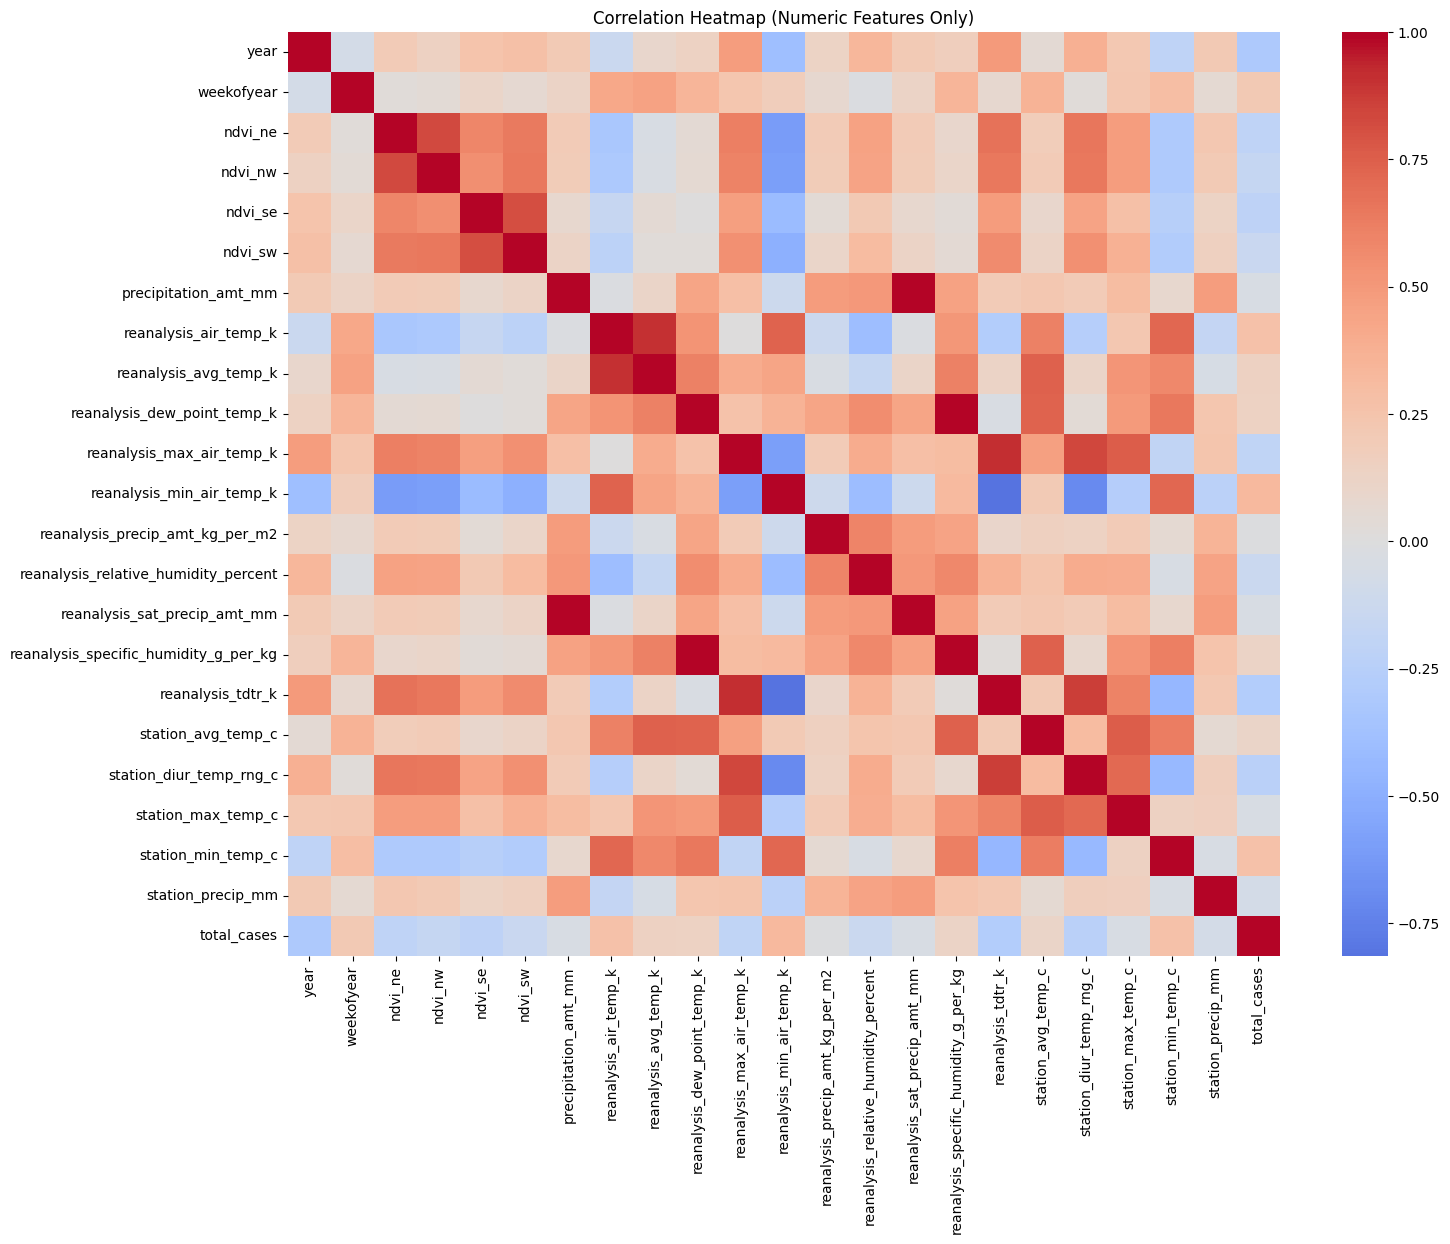

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Sadece sayısal kolonları al
num_df = df_clean.select_dtypes(include="number")

# 2) Korelasyon matrisi
corr = num_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


In [ ]:
corr["total_cases"].sort_values(ascending=False)



total_cases                              1.000000
reanalysis_min_air_temp_k                0.325222
station_min_temp_c                       0.264639
reanalysis_air_temp_k                    0.262753
weekofyear                               0.216452
reanalysis_avg_temp_k                    0.148120
reanalysis_dew_point_temp_k              0.138729
reanalysis_specific_humidity_g_per_kg    0.126061
station_avg_temp_c                       0.113445
reanalysis_precip_amt_kg_per_m2         -0.011605
station_max_temp_c                      -0.040772
reanalysis_sat_precip_amt_mm            -0.041801
precipitation_amt_mm                    -0.041801
station_precip_mm                       -0.073901
reanalysis_relative_humidity_percent    -0.134470
ndvi_sw                                 -0.145441
ndvi_nw                                 -0.167659
reanalysis_max_air_temp_k               -0.193436
ndvi_ne                                 -0.205673
ndvi_se                                 -0.214030


In [ ]:
# Hangi özellik total_cases ile yüksek pozitif ilişkili?
# Hangileri negatif ilişkili?
# Hangileri tamamen alakasız?

# reanalysis_min_air_temp_k (+0.325)
# Minimum hava sıcaklığı arttıkça vakalar artıyor.
# Sivrisineklerin yaşaması için düşük sıcaklık sınırı yükselince popülasyon artıyor.

# station_min_temp_c (+0.266)
# İstasyon tarafından ölçülen minimum sıcaklık.
# Minimum sıcaklık yükseldikçe sivrisinekler daha fazla hayatta kalıyor.

# reanalysis_air_temp_k (+0.262)
# Ortalama hava sıcaklığı.
# Dengue vakalarının sıcak iklimlerde arttığını doğruluyor.

# weekofyear (+0.216)
# Sezon etkisi var.
# Yılın belli dönemlerinde vakalar artıyor (özellikle yağış ve sıcaklık uygun olduğunda).
# Baştaki yorumlarım bitki örtüsü artarsa nem artar dedim sivrisinek artar dengue artar dedim ama öyle olmadığını gördüm.

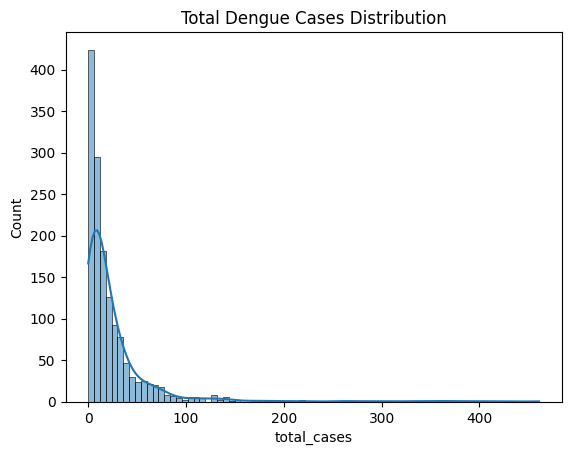

In [ ]:
sns.histplot(df_clean["total_cases"], kde=True)
plt.title("Total Dengue Cases Distribution")
plt.show()

In [ ]:
# Dağılım sağa çarpık (right-skewed)
# Grafikte görüldüğü gibi:
# Çoğu haftada dengue vakası 0 ile 20 arasında.
# 50+ vaka olan haftalar çok daha az.
# 100+ vaka olan haftalar daha da az.
# 400+ vaka gibi uç değerler (outliers) var ama çok seyrek.
# Bu durum bize şunu anlatır:
# Vakalar nadiren patlıyor, çoğu zaman düşük seyrediyor.
# Bu tam olarak bir count data + overdispersion problemidir

# ✔ Linear Regression — kötü seçim
# Çünkü normal dağılım beklentisini bozar. Residual’lar patlar.
# ✔ Poisson Regression — yetmez
# Poisson, mean = variance olmasını bekler.
# Ama bu grafikte variance > mean (overdispersion). Poisson bozulur.
# Negative Binomial Regression — en uygun istatistiksel model
# Bu yarışmada drivendata'nın raporu da aynı şeyi öneriyor.
# Çünkü NB model:
# overdispersion'ı doğal olarak çözer
# sağa çarpık count verilerde çok güçlüdür

# Outlier’lar (çok yüksek vakalar) modele ne yapar?
# Örneğin:
# 200+
# 300+
# 400+
# Bu outlier’lar:
# Lineer modelde eğitimi bozar
# Ağırlıkları şişirir
# RMSE’yi büyütür

# Ama:

# NB Regression bunu tolere eder.
# Gradient Boosting modelleri (XGBoost, RandomForest) outlier’ları iyi yönetir.

# Dengue vakalarının dağılımı sağa çarpık olup düşük vaka sayılarında yoğunlaşmakta,
# yüksek vaka değerleri ise nadir olarak görülmektedir. 
# Bu, klasik regresyon modellerine uygun olmayan bir dağılım olup overdispersion içermektedir.
# Bu nedenle Negative Binomial veya tree-based modeller uygun seçimdir.

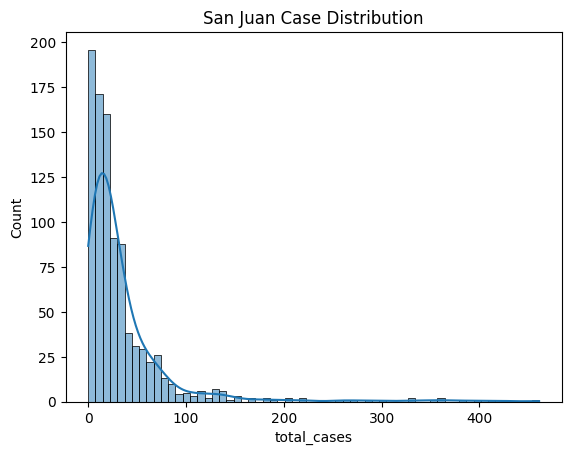

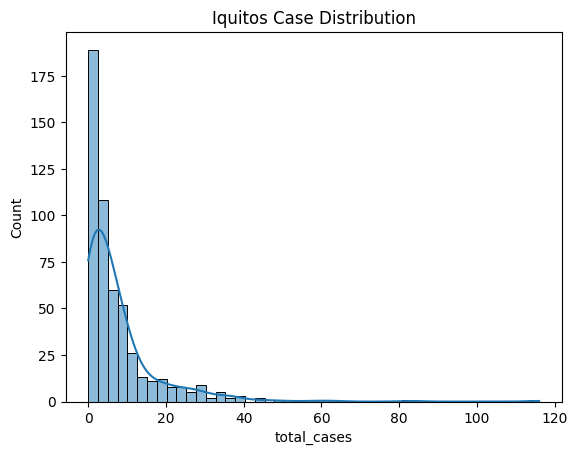

In [ ]:
sns.histplot(df_clean[df_clean["city"]=="sj"]["total_cases"], kde=True)
plt.title("San Juan Case Distribution")
plt.show()

sns.histplot(df_clean[df_clean["city"]=="iq"]["total_cases"], kde=True)
plt.title("Iquitos Case Distribution")
plt.show()

In [ ]:
# SAN JUAN
# San Juan Dağılımı – Aşırı Sağ Kuyruk (Heavy Tail)
# San Juan grafiğinde şunu görüyoruz:
# Vaka sayılarının çoğu 0–50 arasında toplanmış.
# Fakat 200–400+ gibi çok uç değerler var.
# Dağılım simetrik değil, sağa doğru uzun bir kuyruk var.
# Yani çok büyük outlier değerler veri içinde küçük bir yüzdeyi oluşturuyor.
# Bu ne demek?
# San Juan verileri "skewed" -> normal dağılıma yakın değil.

# IQUITOS
# Iquitos Dağılımı – Çok Daha Küçük Vaka Sayıları
# Iquitos grafiği:
# Vaka sayılarının çoğu 0–10 arası.
# Sadece birkaç tane 40–120 arası uç değer var.
# San Juan kadar ekstrem değil ama yine right-skewed (sağa çarpık).

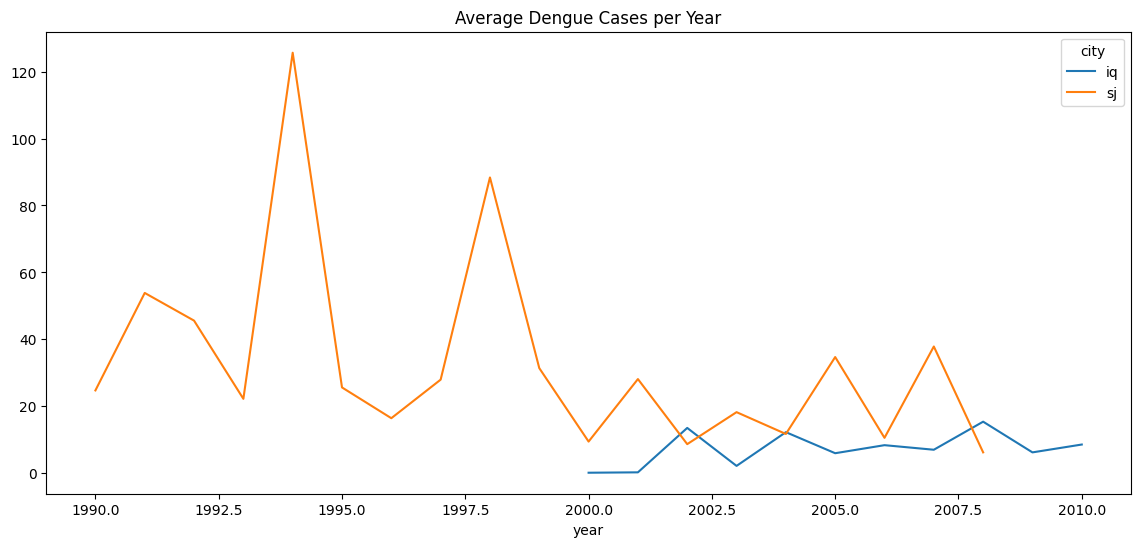

In [ ]:
df_clean.groupby(["year","city"])["total_cases"].mean().unstack().plot(figsize=(14,6))
plt.title("Average Dengue Cases per Year")
plt.show()

In [ ]:
# San Juan (sj) şehri, Iquitos (iq)’dan çok daha yüksek vaka sayısına sahip
# Grafikte turuncu çizgi sj, mavi çizgi iq.
# sj yıllık ortalamalarda bazı yıllarda 80–130 vakaya kadar çıkıyor.
# iq ise neredeyse tüm yıllarda 0–15 vaka arasında.
# Bu bize iki şehrin epidemiyolojik davranışının tamamen farklı olduğunu gösteriyor.
# Bu nedenle modele:
# Bu analiz bize gösterdi ki, iki şehrin dinamikleri çok farklı. Bu yüzden ileride her şehir için ayrı model kuracağım ve city’yi feature olarak kullanmayacağım. 
# Çünkü iki şehrin vaka dinamiği birbirinden tamamen farklı.

# San Juan’da belirgin salgın yılları var
# Grafikte turuncu çizgide sivri “spike” noktaları görüyoruz:
# 1994 civarında büyük bir salgın (ortalama ~130 vaka)
# 1998 civarında bir başka yükseliş (ortalama ~90 vaka)
# Bu yıllar ENSO (El Niño) etkisiyle dengue artışının yaşandığı bilinen yıllardır.
# Bu, projenin gerçek dünyayla uyumlu olduğunu gösteriyor.

# Iquitos’ta ise düşük fakat hafif dalgalı bir artış trendi var
# Mavi çizgi (iq):
# 2000 öncesi çok düşük
# 2002–2010 arasında 10–15 vaka civarında küçük artışlar gösteriyor
# Yani Iquitos’ta değişim daha yumuşak, büyük sıçramalar yok.
# Model açısından:
# iq şehri daha kolay tahmin edilir
# sj şehri büyük dalgalanmalar nedeniyle daha zor

#  Sonuç: Şehirler arasında ciddi epidemiolojik fark var
#  Bu grafik bize şunu söylüyor:
#  sj şehri yüksek riskli, büyük salgınlar yaşıyor
#  iq şehri düşük riskli ve daha stabil seyrediyor
#  Tek bir model iki şehri aynı şekilde ele alamaz
#  Feature engineering şehir bazında farklı etkiler yakalamalı

#  Bu farkı yakalamak için:

# rainfall / humidity / NDVI gibi çevresel etkilerin şehirlere göre farklı işlediğini düşünmeliyiz.

# Şehir bazlı ayrı modeller kurabiliriz.

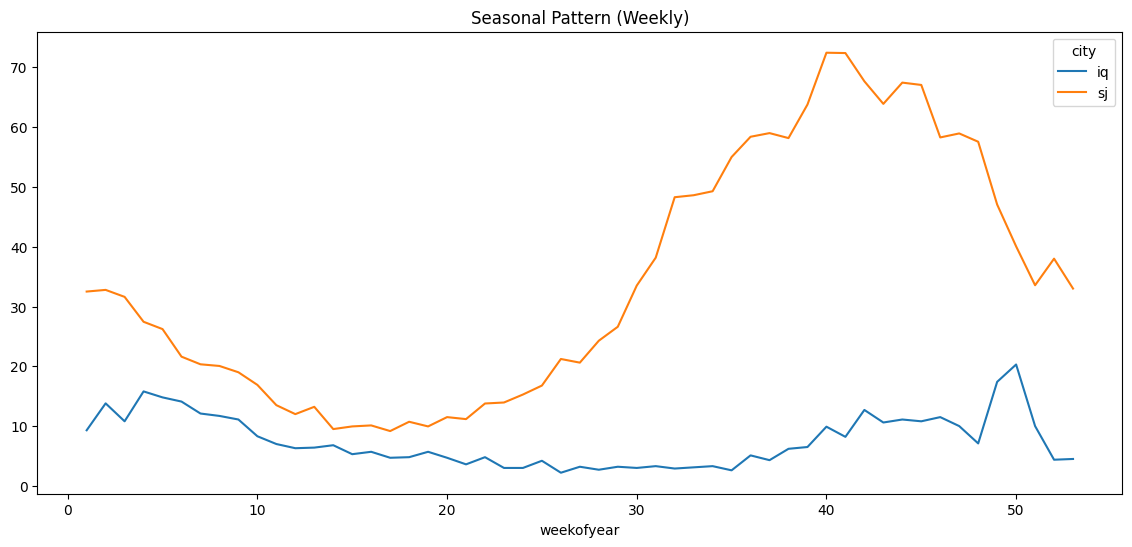

In [ ]:
df_clean.groupby(["weekofyear","city"])["total_cases"].mean().unstack().plot(figsize=(14,6))
plt.title("Seasonal Pattern (Weekly)")
plt.show()

In [ ]:
# X ekseni: yılın haftası (1–52)
# Y ekseni: ortalama vaka sayısı
# Turuncu çizgi (sj): San Juan
# Mavi çizgi (iq): Iquitos
# Dengue vakaları rastgele değil, yılın belirli dönemlerinde zirve yapıyor.
# Epidemi tamamen mevsim döngüsüne bağlı

# San Juan (SJ) – Güçlü Mevsimsel Zirve
# San Juan çizgisi (turuncu):
# Yılın başında yüksek bir başlangıç → sıcak başlangıç iklimi
# 10–20. haftalar → düşüş
# 25. haftadan itibaren → ani yükseliş
# 35–45. haftalar arasında → pik noktası (70+ vaka)
# Yıl sonuna doğru → tekrar düşüş
# Ne demek bu?
# Yılın ortasından sonuna doğru Dengue riski aşırı artıyor.
# Bu dönem:
# sıcaklık stabil
# sivrisinek popülasyonu maksimum
# Bu nedenle San Juan’da daha belirgin ve güçlü bir sezonluk zirve var.

# Iquitos (IQ) – Çok Daha Hafif Zirve
# Iquitos çizgisi (mavi):
# Vakalar çok düşük (0–20 civarı)
# 5–15. haftalarda hafif bir yükseliş
# haftadan itibaren küçük bir artış
# haftaya doğru hafif bir pik
# Ama hiçbir zaman San Juan kadar yükselmiyor

In [24]:
# 2 şehir farklı davrandığı için ve fazla benzer olmadığı için korelasyonu 2 farklı şehir için alcam.


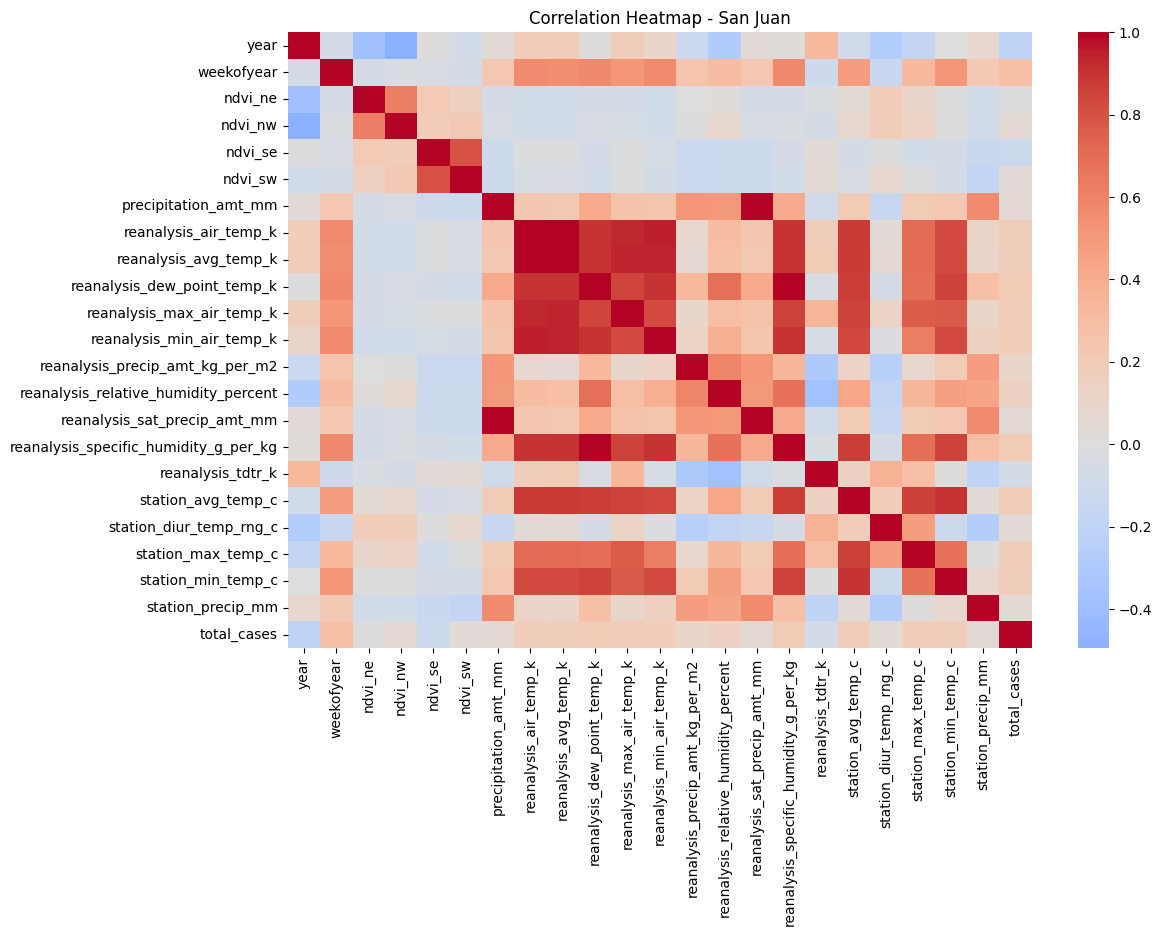

In [25]:
df_sj = df_clean[df_clean["city"] == "sj"]

# Sadece sayısal kolonları al
df_sj_num = df_sj.select_dtypes(include=["float64", "int64"])

plt.figure(figsize=(12,8))
sns.heatmap(df_sj_num.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - San Juan")
plt.show()


In [26]:
df_sj_num = df_sj.select_dtypes(include=["float64", "int64"])
df_sj_num.corr()["total_cases"].sort_values(ascending=False)


total_cases                              1.000000
weekofyear                               0.287134
reanalysis_specific_humidity_g_per_kg    0.205037
reanalysis_dew_point_temp_k              0.200756
station_avg_temp_c                       0.193868
reanalysis_max_air_temp_k                0.191750
station_max_temp_c                       0.186691
reanalysis_min_air_temp_k                0.184839
reanalysis_air_temp_k                    0.178611
station_min_temp_c                       0.174661
reanalysis_avg_temp_k                    0.171747
reanalysis_relative_humidity_percent     0.143134
reanalysis_precip_amt_kg_per_m2          0.106889
ndvi_nw                                  0.060041
precipitation_amt_mm                     0.058762
reanalysis_sat_precip_amt_mm             0.058762
station_precip_mm                        0.050895
ndvi_sw                                  0.039079
station_diur_temp_rng_c                  0.033720
ndvi_ne                                  0.003108


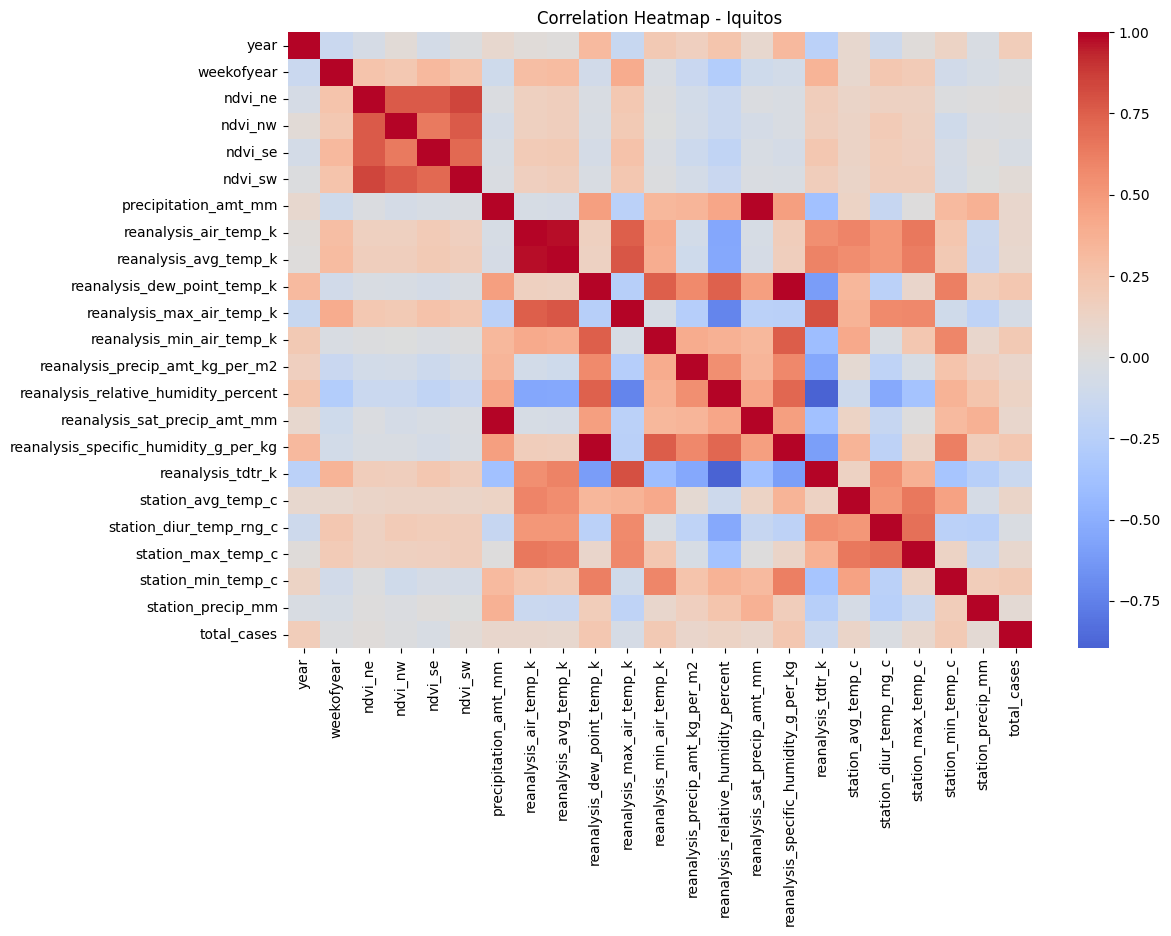

In [27]:
df_iq = df_clean[df_clean["city"] == "iq"]

df_iq_num = df_iq.select_dtypes(include=["float64", "int64"])

plt.figure(figsize=(12,8))
sns.heatmap(df_iq_num.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - Iquitos")
plt.show()


In [28]:
df_iq_num = df_iq.select_dtypes(include=["float64", "int64"])
df_iq_num.corr()["total_cases"].sort_values(ascending=False)


total_cases                              1.000000
reanalysis_specific_humidity_g_per_kg    0.235799
reanalysis_dew_point_temp_k              0.229682
reanalysis_min_air_temp_k                0.213122
station_min_temp_c                       0.202283
year                                     0.179451
reanalysis_relative_humidity_percent     0.130109
station_avg_temp_c                       0.116934
reanalysis_precip_amt_kg_per_m2          0.101803
reanalysis_air_temp_k                    0.095569
reanalysis_sat_precip_amt_mm             0.090780
precipitation_amt_mm                     0.090780
station_max_temp_c                       0.078634
reanalysis_avg_temp_k                    0.078351
station_precip_mm                        0.045439
ndvi_sw                                  0.030537
ndvi_ne                                  0.017716
ndvi_nw                                 -0.010711
weekofyear                              -0.011850
station_diur_temp_rng_c                 -0.022174


In [ ]:
 

df_sj_num = df_sj.select_dtypes(include=["float64", "int64"])
df_iq_num = df_iq.select_dtypes(include=["float64", "int64"])


In [30]:
corr_sj = df_sj_num.corr()["total_cases"]
corr_iq = df_iq_num.corr()["total_cases"]


In [31]:
comparison_df = pd.DataFrame({
    "San Juan (sj)": corr_sj,
    "Iquitos (iq)": corr_iq
})

comparison_df.sort_values("San Juan (sj)", ascending=False)


,San Juan (sj),Iquitos (iq)
total_cases,1.000000,1.000000
weekofyear,0.287134,-0.011850
reanalysis_specific_humidity_g_per_kg,0.205037,0.235799
reanalysis_dew_point_temp_k,0.200756,0.229682
station_avg_temp_c,0.193868,0.116934
reanalysis_max_air_temp_k,0.191750,-0.056236
station_max_temp_c,0.186691,0.078634
reanalysis_min_air_temp_k,0.184839,0.213122
reanalysis_air_temp_k,0.178611,0.095569
station_min_temp_c,0.174661,0.202283


In [32]:
# San Juan (sj) ve Iquitos (iq) tamamen farklı iklim yapısına ve farklı dengue tetikleyicilerine sahip. 
# Bu yüzden iki şehir için ayrı model kurmak kesinlikle doğru karar.

# San Juan için en önemli özellikler:
# weekofyear	0.287
# reanalysis_specific_humidity_g_per_kg	0.205
# reanalysis_dew_point_temp_k	0.200
# station_avg_temp_c	0.193
# reanalysis_max_air_temp_k	0.191

# Yorum: San Juan’da dengue = Nem + Çiğ Noktası + Ortalama Sıcaklık + Sezon Etkisi 

# Iquitos için en önemli özellikler:
# reanalysis_specific_humidity_g_per_kg	0.235
# reanalysis_dew_point_temp_k	0.229
# reanalysis_min_air_temp_k	0.213
# station_min_temp_c	0.202
# year	0.179

# Yorum: Iquitos’da dengue = Nem + Minimum sıcaklık + Yıllar içinde artış

# Model için kritik çıkarımlar

# ✔ San Juan modeli şu özellikleri mutlaka içermeli:
# weekofyear
# nem (humidity)
# dew point
# average temp
# max temp

# ✔ Iquitos modeli şu özellikleri mutlaka içermeli:
# nem
# dew point
# minimum sıcaklık
# year
# precipitation (biraz daha önemli)

# İkisinde de:
# humidity
# dew point
# min_air_temp

# San Juan’ın korelasyonları daha net ve güçlü → daha öngörülebilir.
# Iquitos daha karışık, korelasyonlar daha zayıf → daha zor model.

# İki şehir için tek model olmaz.
# Her şehrin dengue mekanizması tamamen farklı.
# Feature importance şehir özelinde çıkarılmalı.

In [33]:
# Temiz veri içinden iki şehri ayır
df_sj = df_clean[df_clean["city"] == "sj"]
df_iq = df_clean[df_clean["city"] == "iq"]

# İlk birkaç satırı göster
print("=== San Juan (sj) HEAD ===")
display(df_sj.head())

print("=== Iquitos (iq) HEAD ===")
display(df_iq.head())


=== San Juan (sj) HEAD ===


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


=== Iquitos (iq) HEAD ===


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
529,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
531,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
533,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
535,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
537,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0
